In [ ]:
!pip install --upgrade pip setuptools wheel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
!pip install lime==0.2.0.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2b10914a362b787a0f0ba1705cb60a82f7cecad0af29b5b8a04381c459173415
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from lime import lime_image


In [ ]:
# Cell 1b: quick TF/GPU check
import tensorflow as tf, sys
print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


Python: 3.12.11
TensorFlow: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Cell 2: download/expose dataset using kagglehub
import kagglehub, os, zipfile, shutil
path = kagglehub.dataset_download("sachinkumar413/covid-pneumonia-normal-chest-xray-images")
print("kagglehub returned:", path)

# The function may return a folder path or a zip path. Normalize to base_dir variable:
if os.path.isdir(path):
    base_dir = path
else:
    # if path is a zip file
    try:
        # if it's a zip, unzip to /content/dataset
        extract_to = '/content/dataset'
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(path, 'r') as z:
            z.extractall(extract_to)
        # try to find top-level folder inside extract_to
        entries = os.listdir(extract_to)
        # if a single directory inside, use it
        if len(entries) == 1 and os.path.isdir(os.path.join(extract_to, entries[0])):
            base_dir = os.path.join(extract_to, entries[0])
        else:
            base_dir = extract_to
    except Exception as e:
        raise RuntimeError(f"Could not extract dataset automatically: {e}")

print("Using base_dir =", base_dir)
# show a few files
for root, dirs, files in os.walk(base_dir):
    print(root, "->", len(files), "files, subdirs:", dirs)
    break


kagglehub returned: /kaggle/input/covid-pneumonia-normal-chest-xray-images
Using base_dir = /kaggle/input/covid-pneumonia-normal-chest-xray-images
/kaggle/input/covid-pneumonia-normal-chest-xray-images -> 0 files, subdirs: ['PNEUMONIA', 'NORMAL', 'COVID']


In [ ]:
# Cell 3: detect train/val/test or fallback to train + split
import os, glob
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

print("Paths exists? train:", os.path.exists(train_dir), "val:", os.path.exists(val_dir), "test:", os.path.exists(test_dir))

# If no val folder, we will use ImageDataGenerator's validation_split
use_val_dir = os.path.exists(val_dir)
if not os.path.exists(train_dir):
    # maybe dataset named differently (e.g., 'Train', 'train_images') — try to detect class folders
    # fallback: if base_dir contains class folders directly, use base_dir as train_dir
    names = [n.lower() for n in os.listdir(base_dir)]
    if 'train' in names:
        train_dir = os.path.join(base_dir, os.listdir(base_dir)[names.index('train')])
    else:
        # assume base_dir has subfolders like 'COVID','PNEUMONIA','NORMAL' and no explicit train/test
        # in that case use base_dir as train_dir and create test split later
        train_dir = base_dir
print("Final train_dir:", train_dir)


Paths exists? train: False val: False test: False
Final train_dir: /kaggle/input/covid-pneumonia-normal-chest-xray-images


In [ ]:
# Cell 4: create ImageDataGenerators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
BATCH = 32

if use_val_dir:
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_flow = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH, class_mode='categorical', shuffle=True)
    val_flow   = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH, class_mode='categorical', shuffle=False)
else:
    # use validation_split on the train folder
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_flow = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH, class_mode='categorical', subset='training', shuffle=True)
    val_flow   = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH, class_mode='categorical', subset='validation', shuffle=False)

# Test set: if explicit test_dir exists use it; else reserve portion of train or use val as test
if os.path.exists(test_dir):
    test_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=1, class_mode='categorical', shuffle=False)
else:
    # fallback: use val_flow as test_flow (not ideal but works if no separate test)
    test_flow = val_flow
print("Classes:", train_flow.class_indices)
num_classes = len(train_flow.class_indices)
print("Num classes:", num_classes)


Found 4183 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.
Classes: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Num classes: 3


In [ ]:
# Cell 5: compute class weights
import numpy as np
from sklearn.utils import class_weight
y_train = train_flow.classes
classes = np.unique(y_train)
cw = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(enumerate(cw))
print("class_weights:", class_weights)


class_weights: {0: np.float64(1.0717396874199334), 1: np.float64(0.9669440591770689), 2: np.float64(0.968287037037037)}


In [ ]:
# Cell 6: define ANN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization

input_shape = (*IMG_SIZE, 3)  # 3 channels (RGB)
model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,995,715 (194.53 MB)

 Trainable params: 50,992,643 (194.52 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [ ]:
# Cell 7: training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('/content/ann_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_flow,
    epochs=15,
    validation_data=val_flow,
    class_weight=class_weights,
    callbacks=[checkpoint, es, rlr]
)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9514 - loss: 0.1411
Epoch 1: val_accuracy improved from -inf to 0.94258, saving model to /content/ann_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.9513 - loss: 0.1412 - val_accuracy: 0.9426 - val_loss: 0.1659 - learning_rate: 6.2500e-06
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9467 - loss: 0.1361
Epoch 2: val_accuracy improved from 0.94258 to 0.95407, saving model to /content/ann_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.9467 - loss: 0.1361 - val_accuracy: 0.9541 - val_loss: 0.1499 - learning_rate: 6.2500e-06
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9519 - loss: 0.1314
Epoch 3: val_accuracy did not improve from 0.95407
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9519 - loss: 0.1314 - val_accuracy: 0.9502 - val_loss: 0.1619 - learning_rate: 6.2500e-06
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9423 - loss: 0.1462
Epoch 4: val_accuracy did not improve from 0.95407
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9424 - loss: 0.1462 - val_accuracy: 0.9502 - val_loss: 0.1462 - learning_rate: 6.2500e-06
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9556 - loss: 0.1240
Epoch 5: val_accuracy improved from 0.95407 to 0.95885, saving model to /content/ann_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 0.9556 - loss: 0.1240 - val_accuracy: 0.9589 - val_loss: 0.1395 - learning_rate: 6.2500e-06
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9502 - loss: 0.1311
Epoch 6: val_accuracy did not improve from 0.95885
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9502 - loss: 0.1311 - val_accuracy: 0.9464 - val_loss: 0.1447 - learning_rate: 6.2500e-06
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9520 - loss: 0.1328
Epoch 7: val_accuracy did not improve from 0.95885
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.9520 - loss: 0.1328 - val_accuracy: 0.9560 - val_loss: 0.1431 - learning_rate: 6.2500e-06
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9515 - loss: 0.1330
Epoch 8: val_accuracy did not improve from 0.95885

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9515 - loss

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9629 - loss: 0.1126
Test loss: 0.13946443796157837 Test accuracy: 0.95885169506073
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
Classification report:
              precision    recall  f1-score   support

       COVID       0.98      0.97      0.98       325
      NORMAL       0.97      0.94      0.95       360
   PNEUMONIA       0.93      0.97      0.95       360

    accuracy                           0.96      1045
   macro avg       0.96      0.96      0.96      1045
weighted avg       0.96      0.96      0.96      1045

Confusion matrix:
 [[315   1   9]
 [  4 339  17]
 [  1  11 348]]


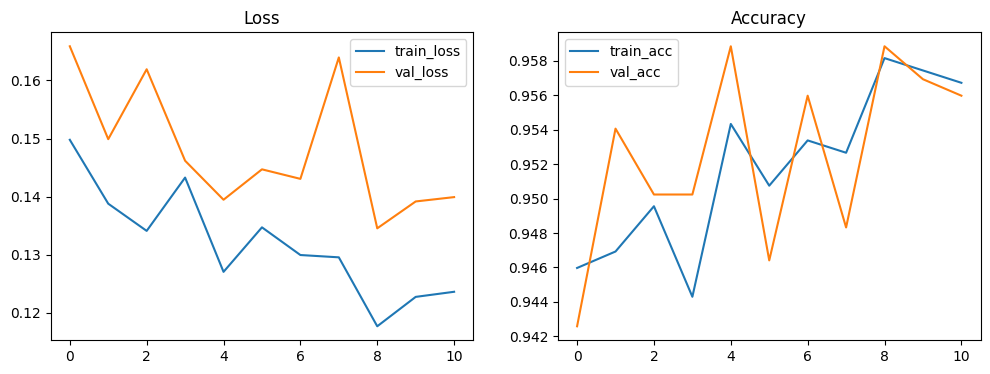

In [ ]:
# Cell 8: load best and evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_weights('/content/ann_best.h5')

loss, acc = model.evaluate(test_flow, verbose=1)
print("Test loss:", loss, "Test accuracy:", acc)

# Predictions
test_flow.reset()
preds = model.predict(test_flow, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_flow.classes
labels = list(test_flow.class_indices.keys())

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=labels))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


Explaining: /kaggle/input/covid-pneumonia-normal-chest-xray-images/COVID/COVID.png


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━

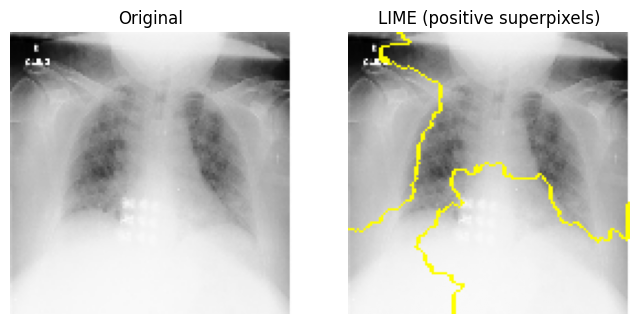

In [ ]:
# Cell 9: LIME explainability
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np, cv2
explainer = lime_image.LimeImageExplainer()

# helper predict function: LIME passes images as numpy arrays (H,W,3) uint8, return probabilities (N, num_classes)
def predict_fn(images):
    # resize + scale to [0,1]
    imgs = np.array([cv2.resize(im, IMG_SIZE) for im in images]).astype('float32') / 255.0
    return model.predict(imgs)

# choose a sample image from test set (index 0) — you can loop over many examples
sample_idx = 0
sample_path = test_flow.filepaths[sample_idx]
print("Explaining:", sample_path)
from tensorflow.keras.preprocessing import image as keras_image
img = keras_image.load_img(sample_path, target_size=IMG_SIZE)
img_arr_uint8 = np.array(img).astype('uint8')

# run LIME (num_samples: lower → faster)
explanation = explainer.explain_instance(img_arr_uint8, classifier_fn=predict_fn, top_labels=num_classes, hide_color=0, num_samples=500)

# pick predicted label to show
pred_label = np.argmax(predict_fn([img_arr_uint8])[0])
print("Model predicted label index:", pred_label, "name:", labels[pred_label])

# get image + mask (positive contributions)
temp, mask = explanation.get_image_and_mask(label=pred_label, positive_only=True, num_features=5, hide_rest=False)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(img_arr_uint8); plt.axis('off')
plt.subplot(1,2,2); plt.title("LIME (positive superpixels)"); plt.imshow(mark_boundaries(temp/255.0, mask)); plt.axis('off')
plt.show()
